# Recognize ages and gender based on VGG Face embeddings

**Materials:**
- [Adience face dataset](https://talhassner.github.io/home/projects/Adience/Adience-data.html), 'adiencedb:adience'
- [Transfer learning with VGGFace for age/gender classification](https://arxiv.org/pdf/1811.07344.pdf)
- [VGGFace on Adience dataset](https://arxiv.org/ftp/arxiv/papers/1709/1709.01664.pdf)
- [VGGFace model repo](https://github.com/cydonia999/VGGFace2-pytorch)

**Aprroach:**
1. Get VGGFace model
2. Train and validate on Adience dataset
3. Get manual estimation of proprietary data

In [1]:
import torch
import pickle
import sys, os

import importlib

In [2]:
project_dir = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
if not project_dir in sys.path: sys.path.append(project_dir)

In [3]:
def load_vggface_model(arch, project_dir, weights_path):
    '''
    Load either a resnet50 or senet50 model
    with pre-trained VGGFace weights
    '''
    # load model
    if arch == 'resnet':
        resnet = importlib.import_module('src.VGGFace2-pytorch.models.resnet', project_dir)
        vggface = resnet.resnet50(num_classes=8631, include_top=True)
    elif arch == 'senet':
        senet = importlib.import_module('src.VGGFace2-pytorch.models.senet', project_dir)
        vggface = senet.senet50(num_classes=8631, include_top=True)
    else:
        raise Exception('Wrong architecture, should be resnet or senet.')
    # load weights into model
    with open(weights_path, 'rb') as f:
        weights = pickle.load(f, encoding='latin1')
    own_state = vggface.state_dict()
    for name, param in weights.items():
        if name in own_state:
            try:
                own_state[name].copy_(torch.from_numpy(param))
            except Exception:
                raise RuntimeError('While copying the parameter named {}, whose dimensions in the model are {} and whose '\
                                   'dimensions in the checkpoint are {}.'.format(name, own_state[name].size(), param.size()))
        else:
            raise KeyError('unexpected key "{}" in state_dict'.format(name))
    return vggface

### Load VGG Face model

In [4]:
weights_path = '../models/external/resnet50_ft_weight.pkl'

vggface = load_vggface_model('resnet', project_dir, weights_path).cuda()

print(vggface)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fa

### Load Data


In [5]:
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [6]:
plot_utils = importlib.import_module('rgutils.plot_utils', project_dir)

##### Visualize faces dataset

In [7]:
DATA_DIR = '../data/external/adience/faces/'
labels_path = '../data/external/adience/fold_0_data.txt'

In [8]:
images = pd.read_table(labels_path,)[['user_id','original_image','face_id']]

In [9]:
def get_image_path(table_row, data_dir):
    fname = '.'.join(['coarse_tilt_aligned_face', str(table_row['face_id']), table_row['original_image']])
    path = os.path.join(data_dir, table_row['user_id'], fname)
    return path

In [10]:
image_paths = []
for i,row in images.iterrows():
    path = get_image_path(row, DATA_DIR)
    image_paths.append(path)

In [11]:
len(image_paths)

4484

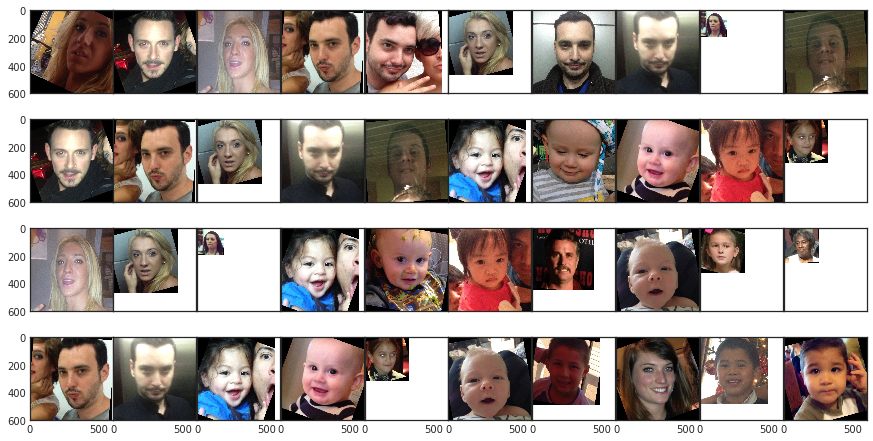

In [12]:
plot_utils.show_images(image_paths[::101], 4, 10, fig_dims=(15, 8))

##### Create data loaders

In [13]:
class AdienceDataset(Dataset):
    '''
    Load face image either with age or gender label
    '''
    def __init__(self, file_paths: list, label_type, data_dir, transforms=None, labels2int=True):
        assert label_type in ['gender', 'age'], 'Label type should be either gender or age'
        self.data = pd.DataFrame()
        for path in file_paths:
            tmp = pd.read_table(path)
            self.data = self.data.append(tmp)
        accepted_label_values = {
                'age': ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', 
                        '(38, 43)', '(48, 53)', '(60, 100)'],
                'gender': ['f','m'],
                }
        self.data[label_type] = self.data[label_type].astype(str)
        self.data = self.data[self.data[label_type].isin(accepted_label_values[label_type])]
        if labels2int:
            self.classes_mapping = {k:v for v,k in enumerate(accepted_label_values[label_type])}
            self.data[label_type] = self.data[label_type].map(self.classes_mapping)
        self.label_type = label_type
        self.data_dir = data_dir
        self.transforms = transforms
        
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = get_image_path(row, self.data_dir)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256,256,), interpolation=cv2.INTER_AREA)
        label = row[self.label_type]
        if self.transforms:
            img = self.transforms(img)
        return img, label

In [14]:
fold0 = '../data/external/adience/fold_0_data.txt'
fold1 = '../data/external/adience/fold_1_data.txt'
fold2 = '../data/external/adience/fold_2_data.txt'
fold3 = '../data/external/adience/fold_3_data.txt'
fold4 = '../data/external/adience/fold_4_data.txt'

In [15]:
img_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(224),
#     transforms.ToTensor(),
])


In [16]:
age_dataset = AdienceDataset([fold1, fold2, fold3,], 'age', DATA_DIR, img_transforms,
                             labels2int=False)
gender_dataset = AdienceDataset([fold0, fold4], 'gender', DATA_DIR, img_transforms,
                               labels2int=False)

In [17]:
len(age_dataset), len(gender_dataset)

(7769, 7440)

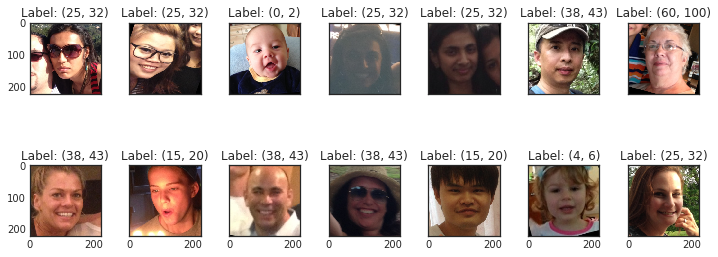

In [18]:
plot_utils.image_labels_grid(2, 7, age_dataset, fig_dims=(12, 5))

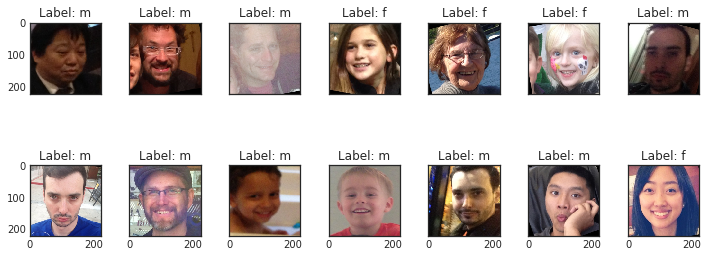

In [19]:
plot_utils.image_labels_grid(2, 7, gender_dataset, fig_dims=(12, 5))

##### Test loader

In [20]:
img_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.45, 0.44, 0.49], [0.25, 0.22, 0.24]),
])

In [21]:
loader = DataLoader(AdienceDataset([fold4], 'gender', DATA_DIR, img_transforms),
                    batch_size=10, shuffle=True, num_workers=4)

In [22]:
for x, y in loader:
    print(x.size())
    print(x.mean(0).mean((1,2)))
    print(np.unique(y, return_counts=True))
    break

torch.Size([10, 3, 224, 224])
tensor([ 0.3726, -0.0895, -0.5381])
(array([0, 1]), array([6, 4]))


### Training parameters

In [23]:
from copy import deepcopy
from torch import optim
import torch.nn as nn

In [24]:
torch_utils = importlib.import_module('rgutils.torch_utils', project_dir)

In [25]:
device = torch.device('cuda')

In [26]:
def customize_network(orig_net, num_classes):
    net = deepcopy(orig_net)
    in_feat = net.fc.in_features
    net.fc = nn.Linear(in_feat, num_classes)
    return net


def freeze_layers(net, trainable_children):
    for child,layers in net.named_children():
        if child in trainable_children:
            for param in layers.parameters():
                param.requires_grad = True
        else:
            for param in layers.parameters():
                param.requires_grad = False
    return net


def create_model(pretrained_network, num_classes, device, trainable_layers=None):
    net = customize_network(pretrained_network, num_classes)
    if trainable_layers:
        net = freeze_layers(net, trainable_layers)
    torch_utils.parameter_number(net)
    return net.to(device)

##### Optimizer and criterion

In [27]:
age_criterion = nn.CrossEntropyLoss()

gender_criterion = nn.BCEWithLogitsLoss()

### Training

In [28]:
from sklearn.model_selection import KFold

In [32]:
def cross_validated_training(cv_folds, eta, num_epoch, warmup_epochs, num_classes, label, 
                             input_transforms, criterion, input_size):
    cv_models = {}
    cv_hist = {}
    for i,fold in enumerate(cv_folds):
        print('=*='*15, 'Fold', i, '=*='*15)
        # data loaders
        train_loader = DataLoader(AdienceDataset(fold['train'], label, DATA_DIR, input_transforms), 
                                  batch_size=BATCH_SIZE, num_workers=4, )
        val_loader = DataLoader(AdienceDataset(fold['val'], label, DATA_DIR, input_transforms), 
                                  batch_size=BATCH_SIZE, num_workers=4, )
        # net
        model = create_model(vggface, num_classes, device, trainable_layers=['fc'])
        # warm up training
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), eta)
        clf_type = 'multi' if label == 'age' else 'binary'
        trainer = torch_utils.Trainer(clf_type, model, optimizer, criterion, device,
                                      input_size, train_loader, val_loader, tqdm_off=False)
        model,history = trainer.run_training(warmup_epochs, ['accuracy'], print_stats=False,)
        ckpt = model.state_dict()
        score_max = max(history['val_accuracy'])
        print(f'Max val accuracy {score_max}')
        # full training
        model = create_model(vggface, num_classes, device, )
        model.load_state_dict(ckpt)
        optimizer = optim.SGD(model.parameters(), eta * 0.1)
        trainer = torch_utils.Trainer(clf_type, model, optimizer, criterion, device,
                                      input_size, train_loader, val_loader, tqdm_off=False)
        model,history = trainer.run_training(num_epoch, ['accuracy'], history=history,
                                             print_stats=False,)
        # best result and save models
        score_max = max(history['val_accuracy'])
        print(f'Max val accuracy {score_max}')
        cv_models[i] = model
        cv_hist[i] = history
        del model, trainer
        torch.cuda.empty_cache()
    return cv_models, cv_hist

In [33]:
folds = np.array([fold0,fold1,fold2,fold3,fold4])

kf = KFold(n_splits=5)

cv_folds = [{'train': list(folds[t_i]), 'val': list(folds[v_i])} for t_i,v_i in kf.split(folds)]

### Train and evaluate ages

In [37]:
input_size = (3,224,224)
eta = 0.01
NUM_EPOCH = 5
N_CLASSES = 8
WARMUP = 5
BATCH_SIZE = 64
cv_models,cv_hist = cross_validated_training(cv_folds, eta, NUM_EPOCH, WARMUP,
                                             N_CLASSES, 'age', 
                                             img_transforms, age_criterion, input_size)

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= Fold 0 =*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=




  0%|          | 0/5 [00:00<?, ?it/s]

Total parameters: 23524424
Trainable parameters: 16392


/home/neuro/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/neuro/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 20%|██        | 1/5 [00:34<02:16, 34.25s/it]

 40%|████      | 2/5 [01:08<01:42, 34.22s/it]

 60%|██████    | 3/5 [01:43<01:08, 34.42s/it]

 80%|████████  | 4/5 [02:17<00:34, 34.28s/it]

100%|██████████| 5/5 [02:52<00:00, 34.58s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

Total parameters: 23524424
Trainable parameters: 23524424




 20%|██        | 1/5 [01:10<04:42, 70.57s/it]

 40%|████      | 2/5 [02:21<03:31, 70.55s/it]

 60%|██████    | 3/5 [03:31<02:21, 70.51s/it]

 80%|████████  | 4/5 [04:42<01:10, 70.67s/it]

100%|██████████| 5/5 [05:53<00:00, 70.71s/it]



Max val accuracy 70.48511047070124
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= Fold 1 =*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=




  0%|          | 0/5 [00:00<?, ?it/s]

Total parameters: 23524424
Trainable parameters: 16392




 20%|██        | 1/5 [00:35<02:20, 35.03s/it]

 40%|████      | 2/5 [01:10<01:45, 35.06s/it]

 60%|██████    | 3/5 [01:45<01:10, 35.13s/it]

 80%|████████  | 4/5 [02:20<00:35, 35.11s/it]

100%|██████████| 5/5 [02:56<00:00, 35.26s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

Total parameters: 23524424
Trainable parameters: 23524424




 20%|██        | 1/5 [01:15<05:00, 75.05s/it]

 40%|████      | 2/5 [02:30<03:45, 75.08s/it]

100%|██████████| 5/5 [06:15<00:00, 75.04s/it]



Max val accuracy 54.95387083834737
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= Fold 2 =*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=




  0%|          | 0/5 [00:00<?, ?it/s]

Total parameters: 23524424
Trainable parameters: 16392




 20%|██        | 1/5 [00:34<02:18, 34.50s/it]

 40%|████      | 2/5 [01:08<01:43, 34.39s/it]

 60%|██████    | 3/5 [01:43<01:08, 34.50s/it]

 80%|████████  | 4/5 [02:18<00:34, 34.64s/it]

100%|██████████| 5/5 [02:53<00:00, 34.94s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

Total parameters: 23524424
Trainable parameters: 23524424




 20%|██        | 1/5 [01:13<04:53, 73.34s/it]

 40%|████      | 2/5 [02:27<03:40, 73.53s/it]

 60%|██████    | 3/5 [03:40<02:27, 73.56s/it]

 80%|████████  | 4/5 [04:54<01:13, 73.56s/it]

100%|██████████| 5/5 [06:07<00:00, 73.52s/it]



Max val accuracy 65.97864768683273
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= Fold 3 =*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=




  0%|          | 0/5 [00:00<?, ?it/s]

Total parameters: 23524424
Trainable parameters: 16392




 20%|██        | 1/5 [00:34<02:16, 34.21s/it]

 40%|████      | 2/5 [01:09<01:43, 34.53s/it]

 60%|██████    | 3/5 [01:45<01:09, 34.97s/it]

 80%|████████  | 4/5 [02:19<00:34, 34.73s/it]

100%|██████████| 5/5 [02:54<00:00, 34.86s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

Total parameters: 23524424
Trainable parameters: 23524424




 20%|██        | 1/5 [01:14<04:59, 74.99s/it]

 40%|████      | 2/5 [02:30<03:45, 75.04s/it]

 60%|██████    | 3/5 [03:45<02:30, 75.06s/it]

 80%|████████  | 4/5 [05:00<01:15, 75.02s/it]

100%|██████████| 5/5 [06:15<00:00, 75.07s/it]



Max val accuracy 51.338199513382
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= Fold 4 =*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=




  0%|          | 0/5 [00:00<?, ?it/s]

Total parameters: 23524424
Trainable parameters: 16392




 20%|██        | 1/5 [00:36<02:23, 36.00s/it]

 40%|████      | 2/5 [01:11<01:47, 35.96s/it]

 60%|██████    | 3/5 [01:46<01:11, 35.60s/it]

 80%|████████  | 4/5 [02:21<00:35, 35.37s/it]

100%|██████████| 5/5 [02:56<00:00, 35.24s/it]



  0%|          | 0/5 [00:00<?, ?it/s]

Total parameters: 23524424
Trainable parameters: 23524424




 20%|██        | 1/5 [01:12<04:49, 72.35s/it]

 40%|████      | 2/5 [02:25<03:37, 72.44s/it]

 60%|██████    | 3/5 [03:37<02:24, 72.44s/it]

 80%|████████  | 4/5 [04:49<01:12, 72.44s/it]

100%|██████████| 5/5 [06:02<00:00, 72.43s/it]



Max val accuracy 58.81294964028777


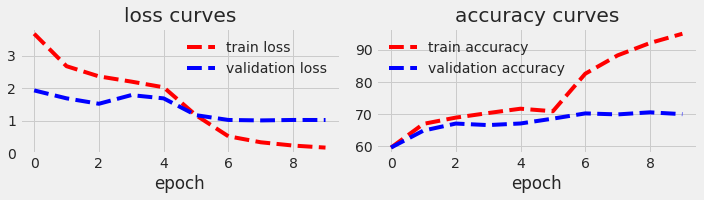

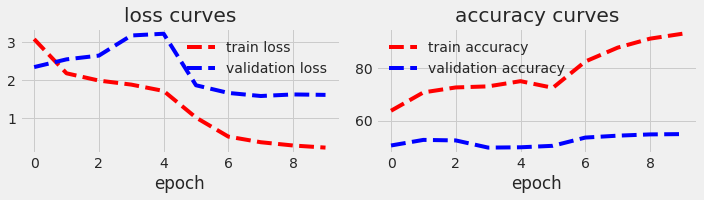

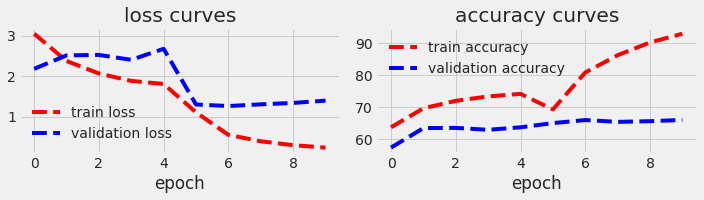

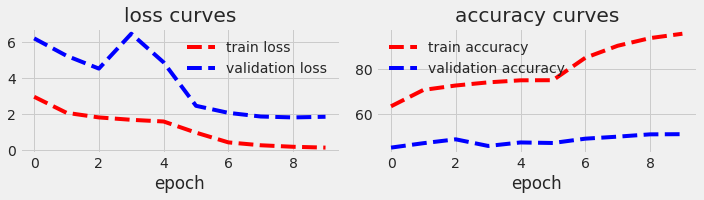

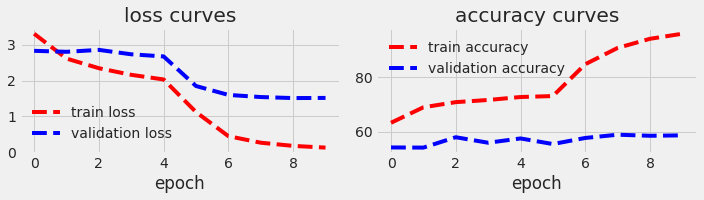

In [39]:
for _,hist in cv_hist.items():
    plot_utils.plot_learning_curve(hist, metrics=['loss','accuracy'], grid=(1,2), fig_shape=(10,3))

### Train and evaluate genders